# Biodiversity in US National Parks

##  Overview

We have two CSV files:

`species_info.csv` has data about different species in our National Parks, including:
- The scientific name of each species
- The common names of each species
- The species conservation status

And, `observations.csv` contains conservationists record sightings of different species at several national parks over a period of 7 days.

## We'll first look at the Species data

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# load the data
species = pd.read_csv('species_info.csv')

### Check the **Species** data:

In [2]:
# Rename columns
species.columns = [x.replace(' ','_').lower() for x in species.columns]
species.head(3)

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN


In [3]:
# Check type of columns is as expected
species.dtypes

category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object

In [4]:
# Check for duplicated rows
species.duplicated().sum()

0

In [5]:
# Check for missing data
species.isna().sum()

category                  0
scientific_name           0
common_names              0
conservation_status    5633
dtype: int64

Let's look into `conservation_status` column and its *NaN* values:

In [6]:
print("There are {} different conservation status: ".format(species.conservation_status.nunique()))
print(list(species.conservation_status.unique()))
print("{} out of {} species have a recorded conservation status."
      .format(len(species)-species.conservation_status.isna().sum(),len(species)))

There are 4 different conservation status: 
[nan, 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
191 out of 5824 species have a recorded conservation status.


### How many species are recorded within each of the conservation status? 

The column `conservation_status` has several possible values:
- `Species of Concern`: declining or appear to be in need of conservation
- `Threatened`: vulnerable to endangerment in the near future
- `Endangered`: seriously at risk of extinction
- `In Recovery`: formerly `Endangered`, but currnetly neither in danger of extinction throughout all or a significant portion of its range

*NaN* don't represent missing info in this case but rather that species are not in danger. Therefore we'll be marking them as: **No Intervention**.

In [7]:
species.fillna('No Intervention', inplace=True)

We can now group and count the species by `conservation_status`

In [8]:
protection_counts = species.groupby('conservation_status') \
    .scientific_name.nunique().reset_index() \
    .sort_values(by='scientific_name') \

#protection_counts

We can also visualise this with a bar plot:

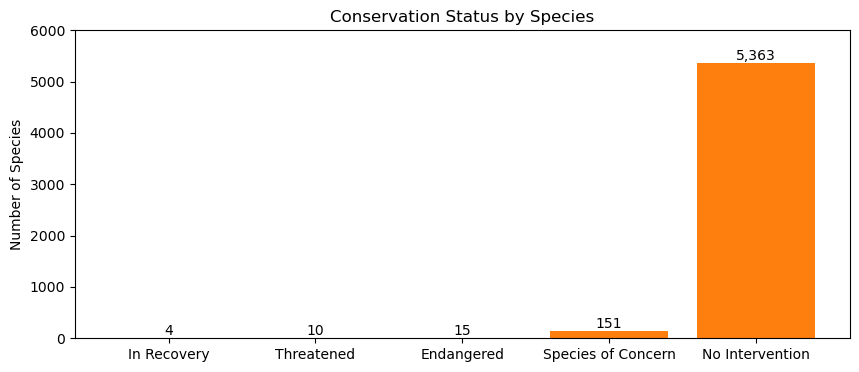

In [9]:
plt.figure(figsize=(10, 4))
ax = plt.subplot()
x = range(len(protection_counts))
plt.bar(x,protection_counts.scientific_name.values)
#ax.set_xticks(x)
#ax.set_xticklabels(protection_counts.conservation_status.values)
bar_container = ax.bar(protection_counts.conservation_status.values,protection_counts.scientific_name.values)
ax.bar_label(bar_container, fmt='{:,.0f}')
plt.ylabel("Number of Species")
plt.ylim(0,6000)
plt.title("Conservation Status by Species")
plt.show()

### Are certain types of species more likely to be endangered?

We'll create a new column in `species` called `protected`, which is `True` if `conservation_status` is not equal to `No Intervention`, and `False` otherwise.

In [10]:
species['protected'] = species.conservation_status \
    .apply(lambda x: True if x != "No Intervention" else False)

species.head(3)

,category,scientific_name,common_names,conservation_status,protected
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False


We can now group the species by `category`and `protected` in a pivot table to get an idea of whether types of species are inequally endangered:  

In [11]:
category_counts = species.groupby(['category','protected']).scientific_name.nunique().reset_index()

category_pivot = category_counts \
    .pivot(index='category', columns='protected', values='scientific_name') \
    .reset_index() \

category_pivot.columns = ['category', 'not_protected', 'protected']

category_pivot['%'] = category_pivot.protected \
    / (category_pivot.protected + category_pivot.not_protected) * 100

category_pivot.sort_values(by='%',ascending=False)

,category,not_protected,protected,%
3,Mammal,146,30,17.045455
1,Bird,413,75,15.368852
0,Amphibian,72,7,8.860759
2,Fish,115,11,8.730159
5,Reptile,73,5,6.410256
4,Nonvascular Plant,328,5,1.501502
6,Vascular Plant,4216,46,1.079305


It looks like **Mammals** are more likely to be endangered. However **Birds** are a close second - Let's see if Mammals are (statistically) significantly more endangered than birds by conducting a *chi squared test*:

Create a contingency table (looks like this):

||protected|not protected|
|-|-|-|
|Mammal|?|?|
|Bird|?|?|

In [12]:
contingency = [
    [30, 146],
    [75, 413],
]

In [13]:
# Let's import the relevnant module from stats:
from scipy.stats import chi2_contingency

In [14]:
# Run test:
_,pval,_,_ = chi2_contingency(contingency)

# We'll use the commonly accepted significance level of 0.05
if pval < 0.05:
    print("Looks like the difference IS significant!")
else:
    print("Looks like the difference IS NOT significant!")

Looks like the difference IS NOT significant!


**Let's test another.**  
Is the difference between `Reptile` and `Mammal` significant?

In [15]:
contingency_RM = [
    [30, 146],
    [5, 73],
]

_,pvalRM,_,_ = chi2_contingency(contingency_RM)

if pvalRM < 0.05:
    print("Looks like the difference IS significant!")
else:
    print("Looks like the difference IS NOT significant!")

Looks like the difference IS significant!


## We'll now look at the Observation data

In [16]:
observations = pd.read_csv('observations.csv')
observations.head(3)

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138


In [17]:
# Check type of columns is as expected
observations.dtypes

scientific_name    object
park_name          object
observations        int64
dtype: object

In [18]:
# Check for duplicated rows

observations[observations.duplicated()]
observations[observations.duplicated(subset=['scientific_name', 'park_name'])]


,scientific_name,park_name,observations
483,Agrostis gigantea,Yellowstone National Park,235
490,Agrostis mertensii,Yosemite National Park,128
945,Rumex crispus,Yellowstone National Park,255
1213,Dianthus barbatus,Bryce National Park,110
1259,Riparia riparia,Bryce National Park,91
...,...,...,...
23258,Microtus longicaudus,Yellowstone National Park,244
23259,Agrostis scabra,Bryce National Park,118
23267,Oxalis corniculata,Yosemite National Park,164
23273,Dactylis glomerata,Bryce National Park,89


We **won't** drop duplicates in this case as the recorded observation where taken over 7 days, meaning the same species in the same parks could have been observed the same number of times. 

In [19]:
# Check for missing data
observations.isna().sum()

scientific_name    0
park_name          0
observations       0
dtype: int64

No missing data - great!

### Today we're going to focus on the sighting of different **sheep** species - but the same analysis could be conducted on any other specie.

We'll create a new column `sheep` which is `True` if the `common_names` contains `'Sheep'`, and `False` otherwise - to use as a filter:

In [20]:
species['sheep'] = species.common_names.apply(lambda x: True if 'Sheep' in x else False)

In [21]:
species[species.sheep == True]

,category,scientific_name,common_names,conservation_status,protected,sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
1139,Vascular Plant,Rumex acetosella,"Sheep Sorrel, Sheep Sorrell",No Intervention,False,True
2233,Vascular Plant,Festuca filiformis,Fineleaf Sheep Fescue,No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
3758,Vascular Plant,Rumex acetosella,"Common Sheep Sorrel, Field Sorrel, Red Sorrel,...",No Intervention,False,True
3761,Vascular Plant,Rumex paucifolius,"Alpine Sheep Sorrel, Fewleaved Dock, Meadow Dock",No Intervention,False,True
4091,Vascular Plant,Carex illota,"Sheep Sedge, Smallhead Sedge",No Intervention,False,True
4383,Vascular Plant,Potentilla ovina var. ovina,Sheep Cinquefoil,No Intervention,False,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


Some of the results are actually plants - so we need to filter the rows by `category`too `Mammal`:

In [22]:
sheep_species = species[(species.sheep == True) & (species.category == "Mammal")]
sheep_species

,category,scientific_name,common_names,conservation_status,protected,sheep
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,True
3014,Mammal,Ovis canadensis,"Bighorn Sheep, Bighorn Sheep",Species of Concern,True,True
4446,Mammal,Ovis canadensis sierrae,Sierra Nevada Bighorn Sheep,Endangered,True,True


We can now merge `sheep_species` with `observations` (on `scientific_name`) to get a DataFrame with observations of sheep:

In [23]:
sheep_observations = pd.merge(observations,sheep_species)

We can group the observation by park:

In [24]:
obs_by_park = sheep_observations.groupby('park_name').observations.sum() \
    .reset_index().sort_values(by="observations", ascending=False)

obs_by_park

,park_name,observations
2,Yellowstone National Park,507
3,Yosemite National Park,282
0,Bryce National Park,250
1,Great Smoky Mountains National Park,149


We can also visualise this with a bar plot:

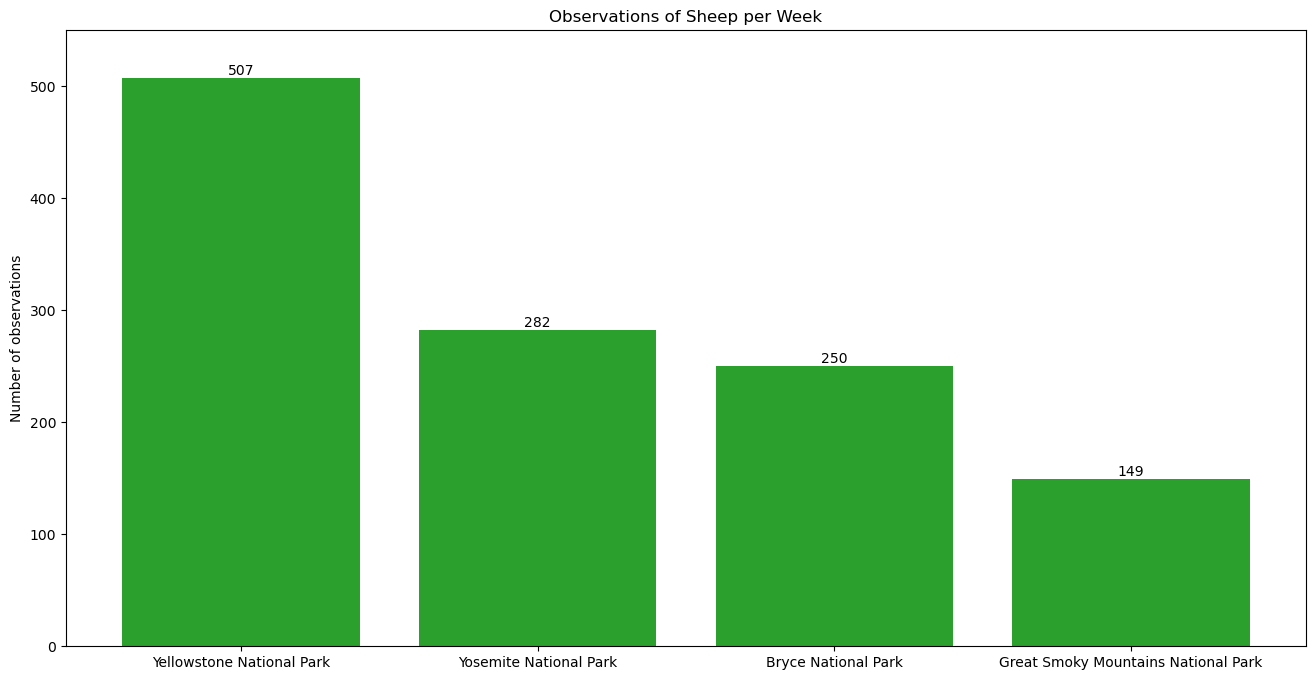

In [25]:
plt.figure(figsize=(16, 8))
ax = plt.subplot()
x = range(len(obs_by_park.observations))
plt.bar(x,obs_by_park.observations)
#ax.set_xticks(x)
#ax.set_xticklabels(obs_by_park.park_name)

plt.bar(x,obs_by_park.observations)
bar_container = ax.bar(obs_by_park.park_name, obs_by_park.observations)
ax.bar_label(bar_container, fmt='{:,.0f}')

plt.ylabel("Number of observations")
plt.ylim(0, 550)
plt.title("Observations of Sheep per Week")

plt.show()